In [1]:
import os
import sys
import pickle
import time

from copy import deepcopy

from cnp.experiment import WorkingDirectory

from cnp.cnp import GaussianNeuralProcess, StandardConvGNP
from cnp.lnp import StandardConvNP
from cnp.architectures import UNet

from cnp.cov import (
    OutputLayer,
    GaussianLayer,
    MeanFieldGaussianLayer,
    InnerprodGaussianLayer,
    KvvGaussianLayer,
    CopulaLayer,
    LogLogitCopulaLayer,
    ExponentialCopulaLayer
)

import numpy as np
import matplotlib.pyplot as plt

import torch

from cnp.encoders import (
    StandardEncoder,
    ConvEncoder,
    ConvPDEncoder,
)

from cnp.decoders import (
    StandardDecoder,
    ConvDecoder,
    ConvPDDecoder,
)

from cnp.experiment import WorkingDirectory

import torch
import torch.nn as nn

from torch.distributions import (
    Normal,
    MultivariateNormal,
    LowRankMultivariateNormal
)

import numpy as np

root = '/scratches/cblgpu07/em626/kernelcnp/kernelcnp/experiments/predator-prey'

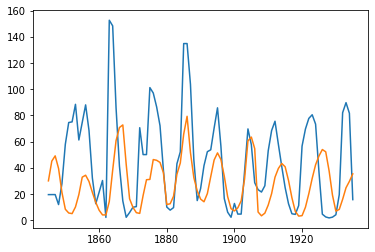

In [2]:
year = np.load(f'{root}/data/year.npy')
hare = np.load(f'{root}/data/hare.npy')
lynx = np.load(f'{root}/data/lynx.npy')

plt.plot(year, hare)
plt.plot(year, lynx)
plt.show()

In [3]:
idx_ctx = np.where(np.logical_or(year < 1880, year > 1900))
idx_trg = np.where(np.logical_and(year >= 1880, year <= 1900))

holdout_task = [{
    'x_context' : torch.tensor(year[idx_ctx])[None, :, None].float(),
    'y_context' : torch.tensor(hare[idx_ctx])[None, :, None].float(),
    'x_target' : torch.tensor(year[idx_trg])[None, :, None].float(),
    'y_target' : torch.tensor(hare[idx_trg])[None, :, None].float()
}]

holdout_tasks = []
    
x_ctx = []
y_ctx = []
x_trg = []
y_trg = []

for i in range(int(year.min()), int(year.max()), 15):
    
    start_year = i
    end_year = i + 15
    
    idx_ctx = np.where(np.logical_or(year < start_year, year > end_year))
    idx_trg = np.where(np.logical_and(year >= start_year, year <= end_year))

    x_ctx.append(torch.tensor(year[idx_ctx])[None, :, None].float())
    y_ctx.append(torch.tensor(hare[idx_ctx])[None, :, None].float())

    x_trg.append(torch.tensor(year[idx_trg])[None, :, None].float())
    y_trg.append(torch.tensor(hare[idx_trg])[None, :, None].float())

holdout_tasks.append({
    'x_context' : torch.cat(x_ctx, axis=0),
    'y_context' : torch.cat(y_ctx, axis=0),
    'x_target' : torch.cat(x_trg, axis=0),
    'y_target' : torch.cat(y_trg, axis=0)
})


subsample_tasks = []
max_num_context = 50

for i in range(512):
    
    num_context = np.random.randint(1, max_num_context)
    
    x_ctx = []
    y_ctx = []
    x_trg = []
    y_trg = []
    
    for i in range(16):
        
        idx_ctx = np.random.choice(np.arange(year.shape[0]),
                                   replace=False,
                                   size=(num_context,))

        _year = year.copy()
        _hare = hare.copy()

        x_ctx.append(torch.tensor(_year[idx_ctx])[None, :, None].float())
        y_ctx.append(torch.tensor(_hare[idx_ctx])[None, :, None].float())

        _year = np.delete(_year, idx_ctx)
        _hare = np.delete(_hare, idx_ctx)

        x_trg.append(torch.tensor(_year)[None, :, None].float())
        y_trg.append(torch.tensor(_hare)[None, :, None].float())

    subsample_tasks.append({
        'x_context' : torch.cat(x_ctx, axis=0),
        'y_context' : torch.cat(y_ctx, axis=0),
        'x_target' : torch.cat(x_trg, axis=0),
        'y_target' : torch.cat(y_trg, axis=0)
    })

In [4]:
save_root = '/scratches/cblgpu07/em626/kernelcnp/kernelcnp/experiments/predator-prey/data'

wd = WorkingDirectory(root=save_root)

with open(wd.file(f'holdout_tasks.pkl'), 'wb') as file:
    pickle.dump(holdout_tasks, file)
    file.close()
    
with open(wd.file(f'subsampled_tasks.pkl'), 'wb') as file:
    pickle.dump(subsample_tasks, file)
    file.close()

Root: /scratches/cblgpu07/em626/kernelcnp/kernelcnp/experiments/predator-prey/data


In [12]:
args_data = 'sim-pred-prey-100-16-50-100-100-0' # 'sim-pred-prey-16-50-100-100-0'
args_cov_type = 'meanfield'
args_noise_type = 'homo'
args_marginal_type = 'exponential'
args_model = 'convGNP'
args_num_basis_dim = 32

args_seed = 0
args_learning_rate = 5e-4
args_weight_decay = 0.
args_validate_every = 1
args_jitter = 1e-4

In [13]:
# # Set seed
# np.random.seed(args_seed)
# torch.manual_seed(args_seed)

# # root = '/Users/stratis/repos/kernelcnp/kernelcnp/experiments/predator-prey'
# root = '/scratches/cblgpu07/em626/kernelcnp/kernelcnp/experiments/predator-prey'

# # Working directory for saving results
# experiment_name = os.path.join(f'{root}',
#                                f'results',
#                                f'{args_data}',
#                                f'models',
#                                f'{args_model}',
#                                f'{args_cov_type}',
#                                f'{args_noise_type}',
#                                f'{args_marginal_type}',
#                                f'seed-{args_seed}')
# working_directory = WorkingDirectory(root=experiment_name)

# # Data directory for loading data
# data_root = os.path.join(f'{root}',
#                          f'simulated-data',
#                          f'{args_data}')
# data_directory = WorkingDirectory(root=data_root)
    
# file = open(working_directory.file('data_location.txt'), 'w')
# file.write(data_directory.root)
# file.close()

# # =============================================================================
# # Load data and validation oracle generator
# # =============================================================================
    
# file = open(data_directory.file('train-data.pkl'), 'rb')
# data_train = pickle.load(file)
# file.close()

# file = open(data_directory.file('valid-data.pkl'), 'rb')
# data_val = pickle.load(file)
# file.close()

In [14]:
# =============================================================================
# Training epoch helper
# =============================================================================

def train(data,
          model,
          optimiser,
          log_every,
          device,
          writer,
          iteration):
    
    for step, batch in enumerate(data):

        nll = model.loss(batch['x_context'][:, :, None].to(device),
                         batch['y_context'][:, 0, :, None].to(device) / 100 + 1e-2,
                         batch['x_target'][:, :, None].to(device),
                         batch['y_target'][:, 0, :, None].to(device) / 100 + 1e-2)
        
        encoder_scale = torch.exp(model.encoder.sigma).detach().cpu().numpy().squeeze()
        decoder_scale = torch.exp(model.decoder.sigma).detach().cpu().numpy().squeeze()

        if step % log_every == 0:
            print(f"Training   neg. log-lik: {nll:.2f}, "
                  f"Encoder/decoder scales {encoder_scale:.3f} "
                  f"{decoder_scale:.3f}")

        # Compute gradients and apply them
        nll.backward()
        optimiser.step()
        optimiser.zero_grad()
        
        iteration = iteration + 1
        
    return iteration


# =============================================================================
# Validation helper
# =============================================================================


def validate(data,
             true_data,
             model,
             device,
             writer,
             latent_model):
    
    # Lists for logging model's training NLL and oracle NLL
    nll_list = []
    nll_true_list = []
    oracle_nll_list = []
    
    # If training a latent model, set the number of latent samples accordingly
    loss_kwargs = {'num_samples' : args_np_val_samples} \
                  if latent_model else {}
    
    with torch.no_grad():
        for step, batch in enumerate(data):
            
            nll = model.loss(batch['x_context'][:, :, None].to(device),
                             batch['y_context'][:, 0, :, None].to(device) / 100 + 1e-2,
                             batch['x_target'][:, :, None].to(device),
                             batch['y_target'][:, 0, :, None].to(device) / 100 + 1e-2,
                             **loss_kwargs)
            
            nll_list.append(nll.item())
            
        for step, batch in enumerate(true_data):
            
            nll_true = model.loss(batch['x_context'].to(device),
                                  batch['y_context'].to(device) / 100 + 1e-2,
                                  batch['x_target'].to(device),
                                  batch['y_target'].to(device) / 100 + 1e-2,
                                  **loss_kwargs)
            
            nll_true_list.append(nll.item())

    mean_nll = np.mean(nll_list)
    std_nll = np.var(nll_list)**0.5
    
    mean_true_nll = np.mean(nll_true_list)
    std_true_nll = np.var(nll_true_list)**0.5

    # Print validation loss and oracle loss
    print(f"Validation neg. log-lik: "
          f"{mean_nll:.2f}")
    
    print(f"True data  neg. log-lik: "
          f"{mean_true_nll:.2f}")

    return mean_nll, std_nll, mean_true_nll, std_true_nll

In [15]:
class StandardConvGNP(GaussianNeuralProcess):
    
    def __init__(self, input_dim, output_layer):
        
        # Standard input/output dimensions and discretisation density
        output_dim = 1
        points_per_unit = 16

        conv_channels = 8
        conv_in_channels = conv_channels
        conv_out_channels = 8
        
        # Standard convolutional architecture
        conv_architecture = UNet(input_dim=input_dim,
                                 in_channels=conv_in_channels,
                                 out_channels=conv_out_channels)

        # Construct the convolutional encoder
        grid_multiplyer =  2 ** conv_architecture.num_halving_layers
        encoder_init_length_scale = 1e-1 # 1.0 / points_per_unit
        decoder_init_length_scale = 1e-1 # 1.0 / points_per_unit
        grid_margin = 5.
        
        encoder = ConvEncoder(input_dim=input_dim,
                              out_channels=conv_channels,
                              init_length_scale=encoder_init_length_scale,
                              points_per_unit=points_per_unit,
                              grid_multiplier=grid_multiplyer,
                              grid_margin=grid_margin)
        
        # Construct the convolutional decoder
        decoder_out_channels = output_layer.num_features
        
        decoder = ConvDecoder(input_dim=input_dim,
                              conv_architecture=conv_architecture,
                              conv_out_channels=conv_architecture.out_channels,
                              out_channels=decoder_out_channels,
                              init_length_scale=decoder_init_length_scale,
                              points_per_unit=points_per_unit,
                              grid_multiplier=grid_multiplyer,
                              grid_margin=grid_margin)


        super().__init__(encoder=encoder,
                         decoder=decoder,
                         output_layer=output_layer)
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.conv_architecture = conv_architecture

In [16]:
# =============================================================================
# Create model
# =============================================================================
    
# Set device
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    
use_cpu = False
device = torch.device('cpu') if use_cpu else torch.device('cuda')

cov_types = {
    'meanfield' : MeanFieldGaussianLayer,
    'innerprod' : InnerprodGaussianLayer,
    'kvv'       : KvvGaussianLayer
}

if args_cov_type == 'meanfield':
    output_layer = MeanFieldGaussianLayer(jitter=args_jitter)
    
else:
    output_layer = cov_types[args_cov_type](num_embedding=args_num_basis_dim,
                                            noise_type=args_noise_type,
                                            jitter=args_jitter)
    
if args_marginal_type == 'exponential':
    output_layer = ExponentialCopulaLayer(gaussian_layer=output_layer,
                                          device=device,
                                          scale=3.)

if args_marginal_type == 'loglogit':
    output_layer = LogLogitCopulaLayer(gaussian_layer=output_layer,
                                       device=device)
    
# Create model architecture
if args_model == 'convGNP':
    model = StandardConvGNP(input_dim=1, output_layer=output_layer)
    
elif args_model == 'convNP':
    model = StandardConvNP(input_dim=1,
                           num_samples=args_np_loss_samples)
    
else:
    raise ValueError(f'Unknown model {args_model}.')

model.to(device)

latent_model = args_model == 'convNP'

print(f'{args_data} '
      f'{args_model} '
      f'{args_cov_type} '
      f'{args_noise_type} '
      f'{args_marginal_type} '
      f'{args_num_basis_dim}: '
      f'{model.num_params}')

sim-pred-prey-100-16-50-100-100-0 convGNP meanfield homo exponential 32: 50701.0


In [17]:
def plot(model, data_train):
    
    e_idx = 2
    i_idx = 0
    b_idx = 0

    train_epoch = data_train[e_idx]

    x_min = torch.min(train_epoch[i_idx]['x_target'][b_idx, :])
    x_max = torch.max(train_epoch[i_idx]['x_target'][b_idx, :])
    x_plot = torch.linspace(x_min-3., x_max+3., 500)[None, :, None].to(device)
    x_plot = x_plot.repeat(train_epoch[i_idx]['x_context'].shape[0], 1, 1).to(device)

    x_ctx = train_epoch[i_idx]['x_context'][:, ::6]
    y_ctx = train_epoch[i_idx]['y_context'][:, :, ::6]

    with torch.no_grad():
        samples = [model.sample(x_ctx[:, :, None].to(device),
                                y_ctx[:, 0, :, None].to(device) / 100 + 1e-2,
                                x_plot,
                                num_samples=3,
                                noiseless=False,
                                double=True)
                   for i in range(10)]
        samples = torch.cat(samples, dim=0)

    plt.figure(figsize=(12, 4))
    plt.plot(x_plot[0, :, 0].cpu().detach().numpy(),
             samples[:, b_idx, :].cpu().detach().numpy().T,
             color='green',
             alpha=0.5,
             zorder=1)

    plt.scatter(x_ctx[b_idx, :].detach().numpy(),
                y_ctx[b_idx, 0, :].detach().numpy() / 100 + 1e-2,
                color='black',
                zorder=2)

    plt.scatter(train_epoch[i_idx]['x_target'][b_idx, :].detach().numpy(),
                train_epoch[i_idx]['y_target'][b_idx, 0, :].detach().numpy() / 100 + 1e-2,
                color='red',
                zorder=2)

    plt.ylim([-1, 4])
    plt.show()


Epoch: 1/101


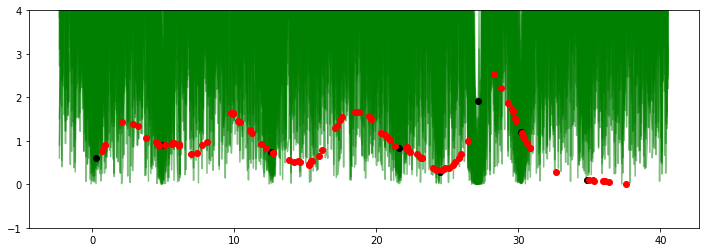

Validation neg. log-lik: 342.91
True data  neg. log-lik: 372.90
Training   neg. log-lik: 338.00, Encoder/decoder scales 0.100 0.100
Training   neg. log-lik: 155.59, Encoder/decoder scales 0.100 0.098
Training   neg. log-lik: 147.36, Encoder/decoder scales 0.100 0.098
Training   neg. log-lik: 134.27, Encoder/decoder scales 0.101 0.098
Training   neg. log-lik: 143.81, Encoder/decoder scales 0.101 0.098
Training   neg. log-lik: 130.97, Encoder/decoder scales 0.102 0.098
Training   neg. log-lik: 126.64, Encoder/decoder scales 0.102 0.099
Training   neg. log-lik: 134.34, Encoder/decoder scales 0.103 0.099
Training   neg. log-lik: 129.67, Encoder/decoder scales 0.104 0.099
Training   neg. log-lik: 135.72, Encoder/decoder scales 0.105 0.099
Training   neg. log-lik: 129.31, Encoder/decoder scales 0.105 0.099

Epoch: 2/101


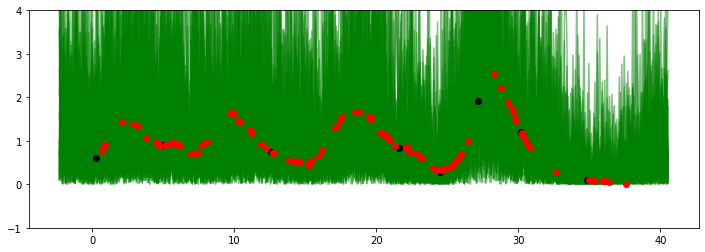

Validation neg. log-lik: 122.82
True data  neg. log-lik: 133.36
Training   neg. log-lik: 123.30, Encoder/decoder scales 0.105 0.099
Training   neg. log-lik: 122.18, Encoder/decoder scales 0.106 0.099
Training   neg. log-lik: 126.89, Encoder/decoder scales 0.106 0.099
Training   neg. log-lik: 117.18, Encoder/decoder scales 0.107 0.099
Training   neg. log-lik: 114.71, Encoder/decoder scales 0.108 0.099
Training   neg. log-lik: 113.74, Encoder/decoder scales 0.108 0.099
Training   neg. log-lik: 118.79, Encoder/decoder scales 0.109 0.099
Training   neg. log-lik: 121.05, Encoder/decoder scales 0.109 0.099
Training   neg. log-lik: 109.98, Encoder/decoder scales 0.110 0.099
Training   neg. log-lik: 109.65, Encoder/decoder scales 0.110 0.099
Training   neg. log-lik: 112.16, Encoder/decoder scales 0.111 0.099

Epoch: 3/101


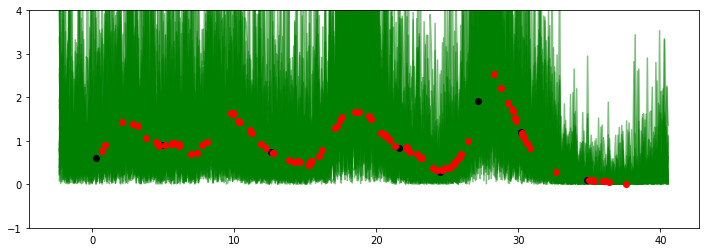

Validation neg. log-lik: 110.12
True data  neg. log-lik: 120.50
Training   neg. log-lik: 107.69, Encoder/decoder scales 0.111 0.100
Training   neg. log-lik: 112.99, Encoder/decoder scales 0.112 0.100
Training   neg. log-lik: 110.48, Encoder/decoder scales 0.112 0.100
Training   neg. log-lik: 117.81, Encoder/decoder scales 0.113 0.100
Training   neg. log-lik: 121.71, Encoder/decoder scales 0.113 0.100
Training   neg. log-lik: 103.18, Encoder/decoder scales 0.114 0.100
Training   neg. log-lik: 117.87, Encoder/decoder scales 0.115 0.100
Training   neg. log-lik: 102.86, Encoder/decoder scales 0.115 0.100
Training   neg. log-lik: 100.21, Encoder/decoder scales 0.116 0.100
Training   neg. log-lik: 98.66, Encoder/decoder scales 0.116 0.100
Training   neg. log-lik: 97.43, Encoder/decoder scales 0.117 0.100

Epoch: 4/101


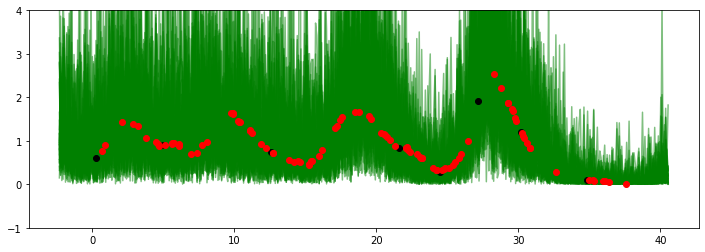

Validation neg. log-lik: 97.93
True data  neg. log-lik: 111.71
Training   neg. log-lik: 98.68, Encoder/decoder scales 0.117 0.100
Training   neg. log-lik: 131.60, Encoder/decoder scales 0.118 0.100
Training   neg. log-lik: 95.93, Encoder/decoder scales 0.119 0.100
Training   neg. log-lik: 91.15, Encoder/decoder scales 0.119 0.100
Training   neg. log-lik: 99.50, Encoder/decoder scales 0.120 0.100
Training   neg. log-lik: 98.44, Encoder/decoder scales 0.122 0.100
Training   neg. log-lik: 90.96, Encoder/decoder scales 0.122 0.100
Training   neg. log-lik: 87.74, Encoder/decoder scales 0.122 0.100
Training   neg. log-lik: 84.16, Encoder/decoder scales 0.123 0.100
Training   neg. log-lik: 86.28, Encoder/decoder scales 0.123 0.100
Training   neg. log-lik: 86.78, Encoder/decoder scales 0.124 0.100

Epoch: 5/101


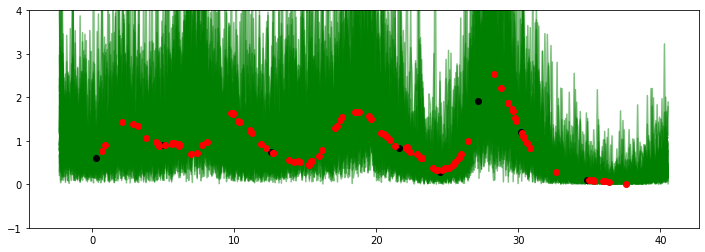

Validation neg. log-lik: 86.78
True data  neg. log-lik: 109.56
Training   neg. log-lik: 82.75, Encoder/decoder scales 0.124 0.100
Training   neg. log-lik: 116.17, Encoder/decoder scales 0.124 0.100
Training   neg. log-lik: 81.77, Encoder/decoder scales 0.124 0.100
Training   neg. log-lik: 82.29, Encoder/decoder scales 0.126 0.100
Training   neg. log-lik: 78.38, Encoder/decoder scales 0.127 0.100
Training   neg. log-lik: 77.38, Encoder/decoder scales 0.127 0.100
Training   neg. log-lik: 77.73, Encoder/decoder scales 0.127 0.100
Training   neg. log-lik: 77.72, Encoder/decoder scales 0.128 0.100
Training   neg. log-lik: 72.58, Encoder/decoder scales 0.129 0.100
Training   neg. log-lik: 75.50, Encoder/decoder scales 0.129 0.100
Training   neg. log-lik: 80.24, Encoder/decoder scales 0.129 0.100

Epoch: 6/101


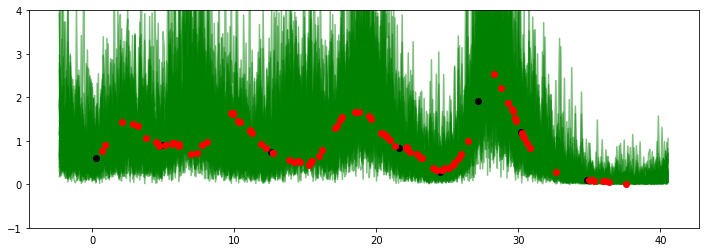

Validation neg. log-lik: 75.06
True data  neg. log-lik: 97.46
Training   neg. log-lik: 72.52, Encoder/decoder scales 0.130 0.101
Training   neg. log-lik: 74.48, Encoder/decoder scales 0.131 0.101
Training   neg. log-lik: 67.47, Encoder/decoder scales 0.131 0.101
Training   neg. log-lik: 74.49, Encoder/decoder scales 0.131 0.100
Training   neg. log-lik: 67.81, Encoder/decoder scales 0.132 0.100
Training   neg. log-lik: 67.59, Encoder/decoder scales 0.133 0.101
Training   neg. log-lik: 61.03, Encoder/decoder scales 0.133 0.101
Training   neg. log-lik: 68.11, Encoder/decoder scales 0.133 0.101
Training   neg. log-lik: 71.73, Encoder/decoder scales 0.133 0.101
Training   neg. log-lik: 67.68, Encoder/decoder scales 0.134 0.101
Training   neg. log-lik: 64.65, Encoder/decoder scales 0.134 0.101

Epoch: 7/101


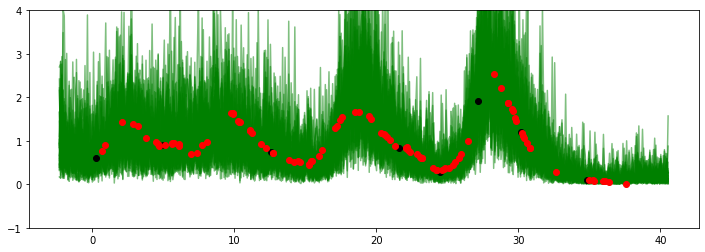

Validation neg. log-lik: 64.24
True data  neg. log-lik: 90.50
Training   neg. log-lik: 59.79, Encoder/decoder scales 0.134 0.101
Training   neg. log-lik: 64.09, Encoder/decoder scales 0.134 0.101
Training   neg. log-lik: 56.23, Encoder/decoder scales 0.135 0.101
Training   neg. log-lik: 58.50, Encoder/decoder scales 0.136 0.101
Training   neg. log-lik: 58.52, Encoder/decoder scales 0.136 0.101
Training   neg. log-lik: 56.20, Encoder/decoder scales 0.136 0.101
Training   neg. log-lik: 55.50, Encoder/decoder scales 0.136 0.101
Training   neg. log-lik: 81.94, Encoder/decoder scales 0.136 0.101
Training   neg. log-lik: 49.61, Encoder/decoder scales 0.135 0.101
Training   neg. log-lik: 67.00, Encoder/decoder scales 0.136 0.101
Training   neg. log-lik: 58.66, Encoder/decoder scales 0.137 0.101

Epoch: 8/101


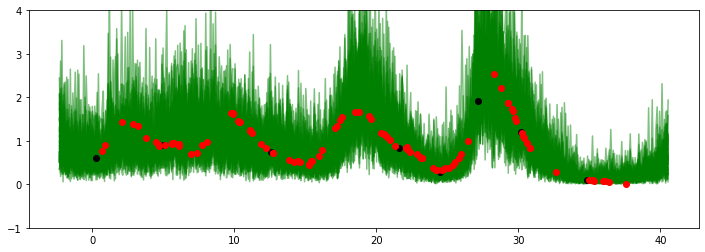

Validation neg. log-lik: 54.57
True data  neg. log-lik: 88.93
Training   neg. log-lik: 52.77, Encoder/decoder scales 0.137 0.101
Training   neg. log-lik: 49.23, Encoder/decoder scales 0.138 0.101
Training   neg. log-lik: 51.24, Encoder/decoder scales 0.138 0.101
Training   neg. log-lik: 44.56, Encoder/decoder scales 0.138 0.101
Training   neg. log-lik: 58.43, Encoder/decoder scales 0.139 0.101
Training   neg. log-lik: 42.72, Encoder/decoder scales 0.139 0.101
Training   neg. log-lik: 80.56, Encoder/decoder scales 0.138 0.101
Training   neg. log-lik: 60.26, Encoder/decoder scales 0.140 0.101
Training   neg. log-lik: 40.85, Encoder/decoder scales 0.141 0.101
Training   neg. log-lik: 36.41, Encoder/decoder scales 0.141 0.101
Training   neg. log-lik: 84.89, Encoder/decoder scales 0.140 0.101

Epoch: 9/101


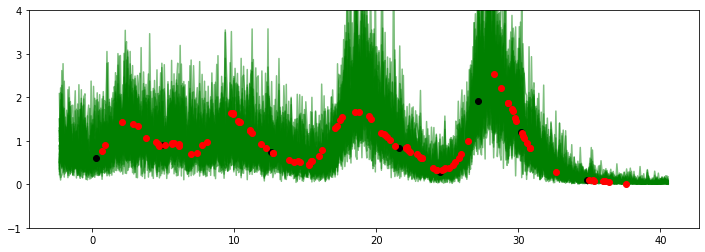

Validation neg. log-lik: 43.73
True data  neg. log-lik: 74.96
Training   neg. log-lik: 53.11, Encoder/decoder scales 0.140 0.101
Training   neg. log-lik: 50.53, Encoder/decoder scales 0.141 0.101
Training   neg. log-lik: 46.16, Encoder/decoder scales 0.141 0.101
Training   neg. log-lik: 35.92, Encoder/decoder scales 0.142 0.101
Training   neg. log-lik: 43.46, Encoder/decoder scales 0.142 0.101
Training   neg. log-lik: 34.24, Encoder/decoder scales 0.142 0.101
Training   neg. log-lik: 83.18, Encoder/decoder scales 0.143 0.101
Training   neg. log-lik: 37.65, Encoder/decoder scales 0.143 0.101
Training   neg. log-lik: 31.52, Encoder/decoder scales 0.144 0.101
Training   neg. log-lik: 45.84, Encoder/decoder scales 0.145 0.101
Training   neg. log-lik: 71.23, Encoder/decoder scales 0.145 0.101

Epoch: 10/101


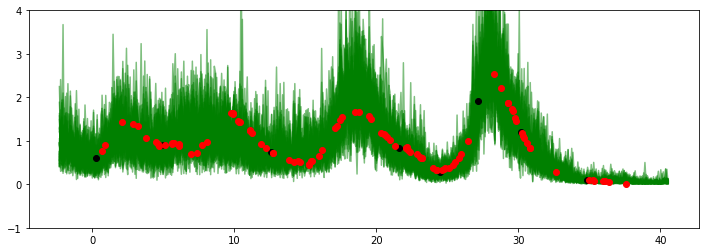

Validation neg. log-lik: 37.01
True data  neg. log-lik: 79.35
Training   neg. log-lik: 139.92, Encoder/decoder scales 0.144 0.101
Training   neg. log-lik: 28.04, Encoder/decoder scales 0.144 0.101
Training   neg. log-lik: 24.28, Encoder/decoder scales 0.144 0.101
Training   neg. log-lik: 26.91, Encoder/decoder scales 0.144 0.101
Training   neg. log-lik: 34.60, Encoder/decoder scales 0.144 0.101
Training   neg. log-lik: 24.73, Encoder/decoder scales 0.145 0.101
Training   neg. log-lik: 63.54, Encoder/decoder scales 0.144 0.101
Training   neg. log-lik: 20.54, Encoder/decoder scales 0.144 0.101
Training   neg. log-lik: 25.81, Encoder/decoder scales 0.144 0.101
Training   neg. log-lik: 107.21, Encoder/decoder scales 0.145 0.101
Training   neg. log-lik: 27.07, Encoder/decoder scales 0.145 0.101

Epoch: 11/101


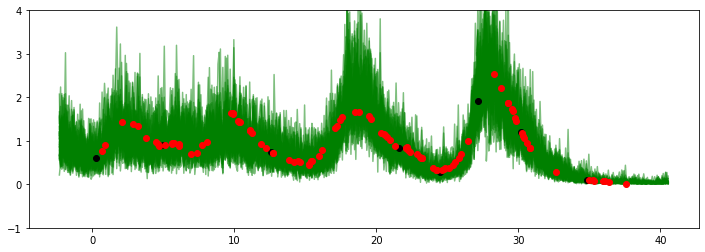

Validation neg. log-lik: 26.69
True data  neg. log-lik: 67.21
Training   neg. log-lik: 20.60, Encoder/decoder scales 0.145 0.101
Training   neg. log-lik: 41.28, Encoder/decoder scales 0.147 0.101
Training   neg. log-lik: 15.49, Encoder/decoder scales 0.147 0.101
Training   neg. log-lik: 23.43, Encoder/decoder scales 0.147 0.101
Training   neg. log-lik: 74.69, Encoder/decoder scales 0.146 0.101
Training   neg. log-lik: 16.53, Encoder/decoder scales 0.146 0.101
Training   neg. log-lik: 35.27, Encoder/decoder scales 0.147 0.101
Training   neg. log-lik: 16.19, Encoder/decoder scales 0.147 0.101
Training   neg. log-lik: 43.70, Encoder/decoder scales 0.146 0.101
Training   neg. log-lik: 19.53, Encoder/decoder scales 0.145 0.101
Training   neg. log-lik: 27.89, Encoder/decoder scales 0.145 0.101

Epoch: 12/101


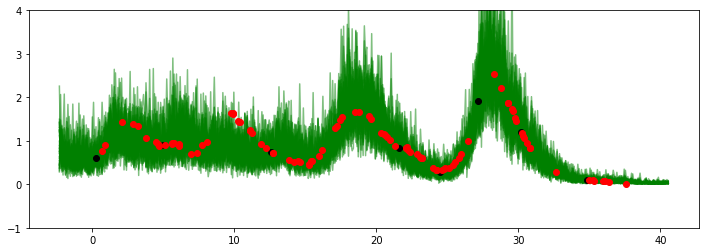

Validation neg. log-lik: 20.48
True data  neg. log-lik: 73.20
Training   neg. log-lik: 12.71, Encoder/decoder scales 0.145 0.101
Training   neg. log-lik: 13.08, Encoder/decoder scales 0.146 0.101
Training   neg. log-lik: 13.64, Encoder/decoder scales 0.146 0.101
Training   neg. log-lik: 9.84, Encoder/decoder scales 0.147 0.101
Training   neg. log-lik: 48.51, Encoder/decoder scales 0.147 0.100
Training   neg. log-lik: 39.35, Encoder/decoder scales 0.148 0.101
Training   neg. log-lik: 10.38, Encoder/decoder scales 0.148 0.101
Training   neg. log-lik: 40.13, Encoder/decoder scales 0.148 0.100
Training   neg. log-lik: 45.91, Encoder/decoder scales 0.148 0.100
Training   neg. log-lik: 15.26, Encoder/decoder scales 0.148 0.101
Training   neg. log-lik: 84.99, Encoder/decoder scales 0.150 0.100

Epoch: 13/101


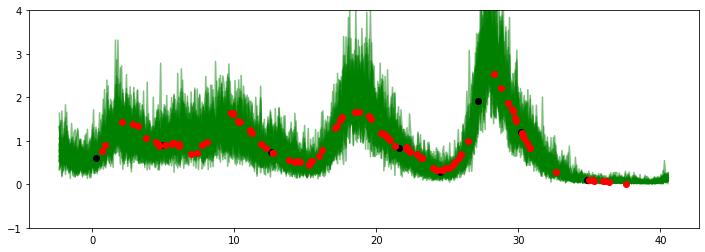

Validation neg. log-lik: 15.47
True data  neg. log-lik: 77.43
Training   neg. log-lik: 31.33, Encoder/decoder scales 0.150 0.101
Training   neg. log-lik: 11.36, Encoder/decoder scales 0.149 0.100
Training   neg. log-lik: 20.81, Encoder/decoder scales 0.150 0.100
Training   neg. log-lik: 4.05, Encoder/decoder scales 0.151 0.100
Training   neg. log-lik: -1.93, Encoder/decoder scales 0.151 0.100
Training   neg. log-lik: 6.86, Encoder/decoder scales 0.152 0.100
Training   neg. log-lik: 8.87, Encoder/decoder scales 0.151 0.100
Training   neg. log-lik: -2.71, Encoder/decoder scales 0.152 0.100
Training   neg. log-lik: -3.20, Encoder/decoder scales 0.152 0.100
Training   neg. log-lik: 29.39, Encoder/decoder scales 0.152 0.100
Training   neg. log-lik: -1.68, Encoder/decoder scales 0.152 0.100

Epoch: 14/101


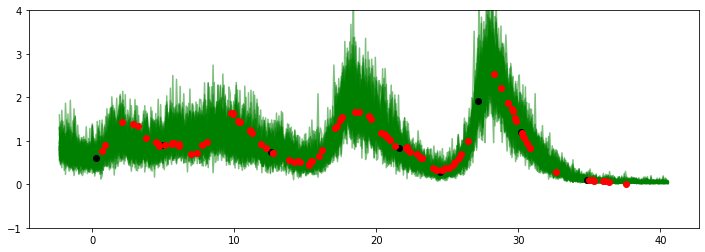

Validation neg. log-lik: 9.49
True data  neg. log-lik: 80.37
Training   neg. log-lik: 71.98, Encoder/decoder scales 0.152 0.100
Training   neg. log-lik: 10.73, Encoder/decoder scales 0.152 0.100
Training   neg. log-lik: -1.14, Encoder/decoder scales 0.150 0.100
Training   neg. log-lik: 7.94, Encoder/decoder scales 0.151 0.100
Training   neg. log-lik: 30.57, Encoder/decoder scales 0.151 0.100
Training   neg. log-lik: -6.20, Encoder/decoder scales 0.151 0.100
Training   neg. log-lik: 3.93, Encoder/decoder scales 0.152 0.100
Training   neg. log-lik: 0.00, Encoder/decoder scales 0.153 0.100
Training   neg. log-lik: 7.06, Encoder/decoder scales 0.153 0.100
Training   neg. log-lik: 7.05, Encoder/decoder scales 0.153 0.100
Training   neg. log-lik: -5.82, Encoder/decoder scales 0.153 0.100

Epoch: 15/101


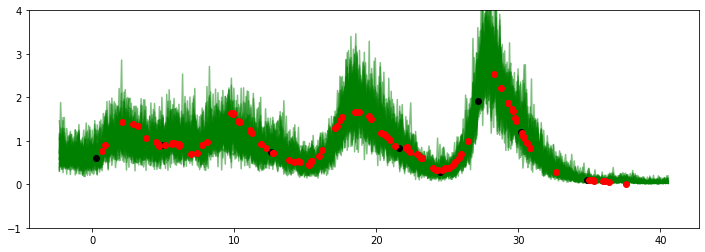

Validation neg. log-lik: 8.21
True data  neg. log-lik: 93.47
Training   neg. log-lik: -2.20, Encoder/decoder scales 0.153 0.100
Training   neg. log-lik: -10.19, Encoder/decoder scales 0.154 0.100
Training   neg. log-lik: 109.46, Encoder/decoder scales 0.153 0.100
Training   neg. log-lik: 4.08, Encoder/decoder scales 0.154 0.100
Training   neg. log-lik: -0.53, Encoder/decoder scales 0.154 0.100
Training   neg. log-lik: -2.23, Encoder/decoder scales 0.154 0.100
Training   neg. log-lik: -8.98, Encoder/decoder scales 0.155 0.100
Training   neg. log-lik: -11.19, Encoder/decoder scales 0.156 0.100
Training   neg. log-lik: -7.33, Encoder/decoder scales 0.156 0.099
Training   neg. log-lik: 6.32, Encoder/decoder scales 0.157 0.099
Training   neg. log-lik: 92.44, Encoder/decoder scales 0.157 0.099

Epoch: 16/101


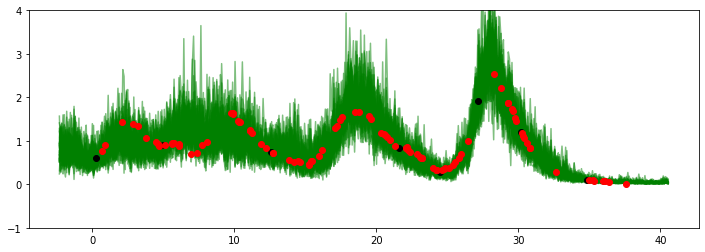

Validation neg. log-lik: 3.88
True data  neg. log-lik: 61.13
Training   neg. log-lik: -1.88, Encoder/decoder scales 0.157 0.099
Training   neg. log-lik: 12.68, Encoder/decoder scales 0.158 0.099
Training   neg. log-lik: 1.41, Encoder/decoder scales 0.158 0.099
Training   neg. log-lik: -8.14, Encoder/decoder scales 0.158 0.098
Training   neg. log-lik: 5.31, Encoder/decoder scales 0.158 0.098
Training   neg. log-lik: -11.61, Encoder/decoder scales 0.158 0.098
Training   neg. log-lik: -8.39, Encoder/decoder scales 0.158 0.098
Training   neg. log-lik: -15.51, Encoder/decoder scales 0.158 0.098
Training   neg. log-lik: -12.64, Encoder/decoder scales 0.157 0.098
Training   neg. log-lik: 18.26, Encoder/decoder scales 0.157 0.098
Training   neg. log-lik: -18.66, Encoder/decoder scales 0.156 0.098

Epoch: 17/101


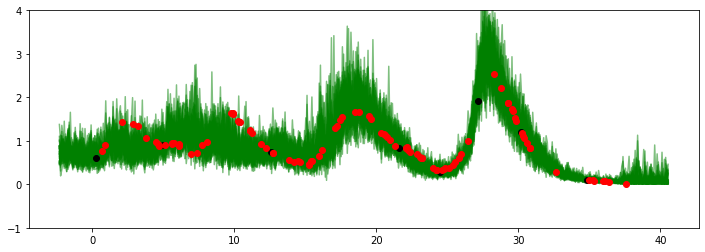

Validation neg. log-lik: -8.66
True data  neg. log-lik: 37.50
Training   neg. log-lik: -19.01, Encoder/decoder scales 0.156 0.098
Training   neg. log-lik: 12.54, Encoder/decoder scales 0.156 0.098
Training   neg. log-lik: -16.29, Encoder/decoder scales 0.155 0.098
Training   neg. log-lik: 34.92, Encoder/decoder scales 0.155 0.098
Training   neg. log-lik: 18.93, Encoder/decoder scales 0.154 0.098
Training   neg. log-lik: -18.09, Encoder/decoder scales 0.153 0.098
Training   neg. log-lik: -20.88, Encoder/decoder scales 0.152 0.098
Training   neg. log-lik: -20.92, Encoder/decoder scales 0.152 0.098
Training   neg. log-lik: 23.19, Encoder/decoder scales 0.152 0.098
Training   neg. log-lik: 69.93, Encoder/decoder scales 0.152 0.098
Training   neg. log-lik: -26.57, Encoder/decoder scales 0.151 0.098

Epoch: 18/101


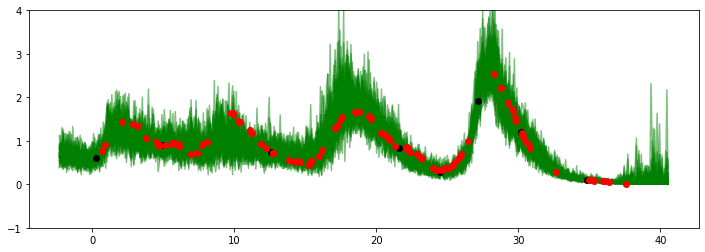

Validation neg. log-lik: -17.60
True data  neg. log-lik: 28.70
Training   neg. log-lik: -30.03, Encoder/decoder scales 0.151 0.098
Training   neg. log-lik: -26.30, Encoder/decoder scales 0.151 0.098
Training   neg. log-lik: -31.84, Encoder/decoder scales 0.151 0.098
Training   neg. log-lik: -21.48, Encoder/decoder scales 0.151 0.098
Training   neg. log-lik: -13.22, Encoder/decoder scales 0.151 0.098
Training   neg. log-lik: 78.76, Encoder/decoder scales 0.150 0.098
Training   neg. log-lik: -33.44, Encoder/decoder scales 0.149 0.098
Training   neg. log-lik: 38.10, Encoder/decoder scales 0.149 0.098
Training   neg. log-lik: -27.03, Encoder/decoder scales 0.149 0.098
Training   neg. log-lik: -28.94, Encoder/decoder scales 0.148 0.098
Training   neg. log-lik: -34.88, Encoder/decoder scales 0.148 0.098

Epoch: 19/101


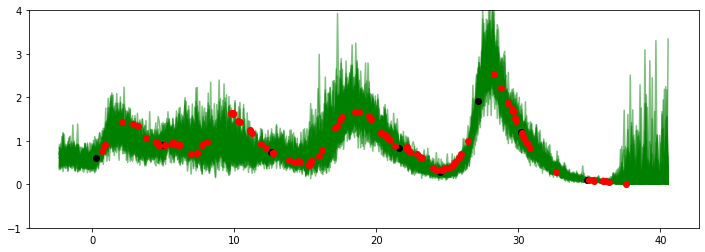

Validation neg. log-lik: -24.30
True data  neg. log-lik: 20.21
Training   neg. log-lik: -25.38, Encoder/decoder scales 0.148 0.098
Training   neg. log-lik: -16.42, Encoder/decoder scales 0.149 0.098
Training   neg. log-lik: 20.49, Encoder/decoder scales 0.148 0.098
Training   neg. log-lik: -31.40, Encoder/decoder scales 0.147 0.098
Training   neg. log-lik: -35.07, Encoder/decoder scales 0.147 0.098
Training   neg. log-lik: -36.85, Encoder/decoder scales 0.147 0.098
Training   neg. log-lik: -37.39, Encoder/decoder scales 0.146 0.098
Training   neg. log-lik: -39.77, Encoder/decoder scales 0.145 0.098
Training   neg. log-lik: -42.36, Encoder/decoder scales 0.144 0.098
Training   neg. log-lik: 28.02, Encoder/decoder scales 0.143 0.098
Training   neg. log-lik: -40.82, Encoder/decoder scales 0.142 0.098

Epoch: 20/101


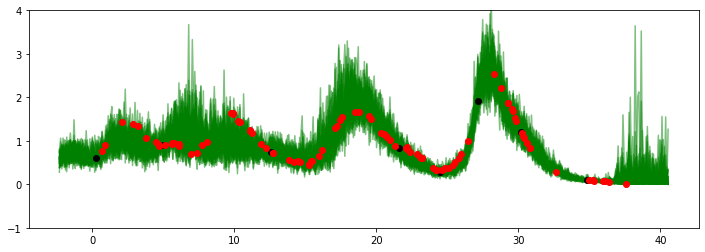

Validation neg. log-lik: -32.43
True data  neg. log-lik: 22.67
Training   neg. log-lik: 10.13, Encoder/decoder scales 0.142 0.098
Training   neg. log-lik: -40.15, Encoder/decoder scales 0.142 0.098
Training   neg. log-lik: -7.41, Encoder/decoder scales 0.142 0.097
Training   neg. log-lik: -28.69, Encoder/decoder scales 0.142 0.098
Training   neg. log-lik: -44.10, Encoder/decoder scales 0.142 0.097
Training   neg. log-lik: -14.76, Encoder/decoder scales 0.142 0.097
Training   neg. log-lik: -45.49, Encoder/decoder scales 0.141 0.097
Training   neg. log-lik: -41.72, Encoder/decoder scales 0.141 0.097
Training   neg. log-lik: -48.83, Encoder/decoder scales 0.140 0.097
Training   neg. log-lik: -12.72, Encoder/decoder scales 0.139 0.097
Training   neg. log-lik: -52.32, Encoder/decoder scales 0.138 0.097

Epoch: 21/101


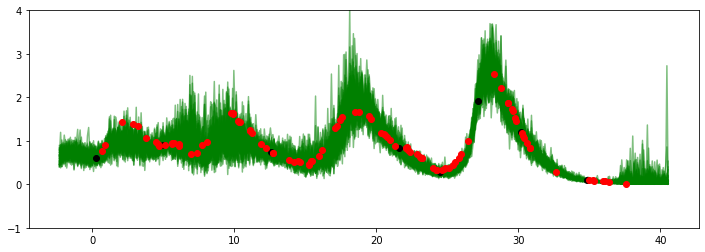

Validation neg. log-lik: -35.66
True data  neg. log-lik: 16.88
Training   neg. log-lik: -39.57, Encoder/decoder scales 0.138 0.097
Training   neg. log-lik: -45.95, Encoder/decoder scales 0.139 0.097
Training   neg. log-lik: -50.63, Encoder/decoder scales 0.138 0.097
Training   neg. log-lik: -24.27, Encoder/decoder scales 0.138 0.097
Training   neg. log-lik: -29.83, Encoder/decoder scales 0.138 0.097
Training   neg. log-lik: 63.54, Encoder/decoder scales 0.138 0.097
Training   neg. log-lik: -44.45, Encoder/decoder scales 0.138 0.097
Training   neg. log-lik: -57.05, Encoder/decoder scales 0.137 0.097
Training   neg. log-lik: -41.30, Encoder/decoder scales 0.137 0.097
Training   neg. log-lik: -45.39, Encoder/decoder scales 0.136 0.097
Training   neg. log-lik: -17.51, Encoder/decoder scales 0.137 0.097

Epoch: 22/101


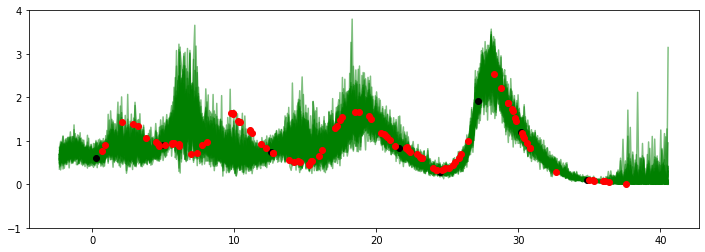

Validation neg. log-lik: -37.98
True data  neg. log-lik: 28.92
Training   neg. log-lik: -44.91, Encoder/decoder scales 0.137 0.097
Training   neg. log-lik: -39.25, Encoder/decoder scales 0.136 0.097
Training   neg. log-lik: 0.86, Encoder/decoder scales 0.136 0.097
Training   neg. log-lik: -32.57, Encoder/decoder scales 0.135 0.097
Training   neg. log-lik: -47.07, Encoder/decoder scales 0.135 0.097
Training   neg. log-lik: -8.41, Encoder/decoder scales 0.135 0.097
Training   neg. log-lik: -52.40, Encoder/decoder scales 0.135 0.097
Training   neg. log-lik: 32.04, Encoder/decoder scales 0.135 0.097
Training   neg. log-lik: 21.07, Encoder/decoder scales 0.135 0.097
Training   neg. log-lik: -44.44, Encoder/decoder scales 0.134 0.097
Training   neg. log-lik: 8.69, Encoder/decoder scales 0.134 0.097

Epoch: 23/101


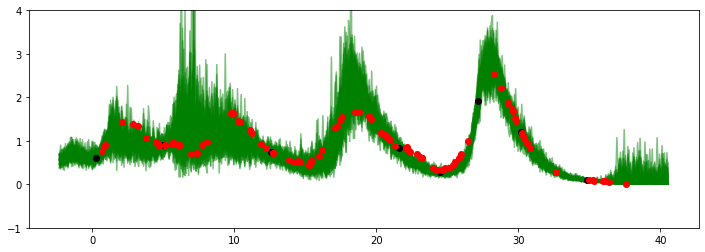

Validation neg. log-lik: -40.27
True data  neg. log-lik: 10.12
Training   neg. log-lik: -54.42, Encoder/decoder scales 0.133 0.097
Training   neg. log-lik: 40.45, Encoder/decoder scales 0.134 0.097
Training   neg. log-lik: -45.64, Encoder/decoder scales 0.134 0.097
Training   neg. log-lik: -55.85, Encoder/decoder scales 0.134 0.097
Training   neg. log-lik: -58.80, Encoder/decoder scales 0.134 0.097
Training   neg. log-lik: -57.43, Encoder/decoder scales 0.133 0.097
Training   neg. log-lik: 23.68, Encoder/decoder scales 0.134 0.097
Training   neg. log-lik: -62.58, Encoder/decoder scales 0.133 0.097
Training   neg. log-lik: -54.76, Encoder/decoder scales 0.133 0.097
Training   neg. log-lik: 28.58, Encoder/decoder scales 0.132 0.097
Training   neg. log-lik: -69.72, Encoder/decoder scales 0.133 0.097

Epoch: 24/101


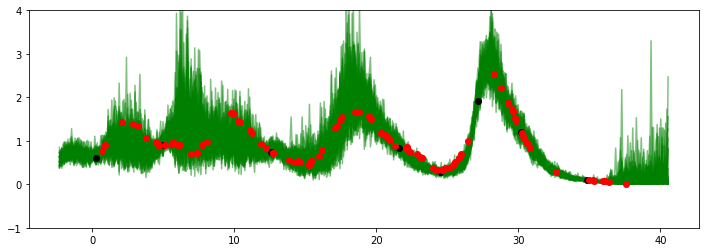

Validation neg. log-lik: -46.58
True data  neg. log-lik: 14.72
Training   neg. log-lik: -49.97, Encoder/decoder scales 0.133 0.097
Training   neg. log-lik: -42.93, Encoder/decoder scales 0.132 0.097
Training   neg. log-lik: -31.35, Encoder/decoder scales 0.133 0.097
Training   neg. log-lik: -62.66, Encoder/decoder scales 0.132 0.097
Training   neg. log-lik: -4.20, Encoder/decoder scales 0.132 0.097
Training   neg. log-lik: -46.04, Encoder/decoder scales 0.132 0.097
Training   neg. log-lik: -50.53, Encoder/decoder scales 0.132 0.097
Training   neg. log-lik: -57.91, Encoder/decoder scales 0.132 0.097
Training   neg. log-lik: -37.16, Encoder/decoder scales 0.131 0.097
Training   neg. log-lik: -32.02, Encoder/decoder scales 0.130 0.097
Training   neg. log-lik: -70.22, Encoder/decoder scales 0.130 0.097

Epoch: 25/101


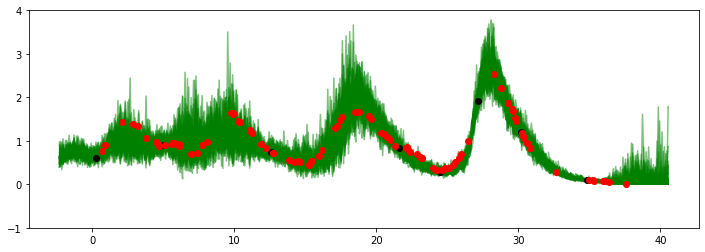

Validation neg. log-lik: -47.54
True data  neg. log-lik: 5.71
Training   neg. log-lik: -62.67, Encoder/decoder scales 0.130 0.097
Training   neg. log-lik: -69.67, Encoder/decoder scales 0.131 0.097
Training   neg. log-lik: -51.97, Encoder/decoder scales 0.130 0.097
Training   neg. log-lik: -61.69, Encoder/decoder scales 0.130 0.097
Training   neg. log-lik: -66.27, Encoder/decoder scales 0.130 0.097
Training   neg. log-lik: -40.25, Encoder/decoder scales 0.130 0.097
Training   neg. log-lik: -73.55, Encoder/decoder scales 0.129 0.097
Training   neg. log-lik: -62.22, Encoder/decoder scales 0.129 0.097
Training   neg. log-lik: -59.46, Encoder/decoder scales 0.129 0.097
Training   neg. log-lik: -43.38, Encoder/decoder scales 0.129 0.097
Training   neg. log-lik: -32.18, Encoder/decoder scales 0.129 0.097

Epoch: 26/101


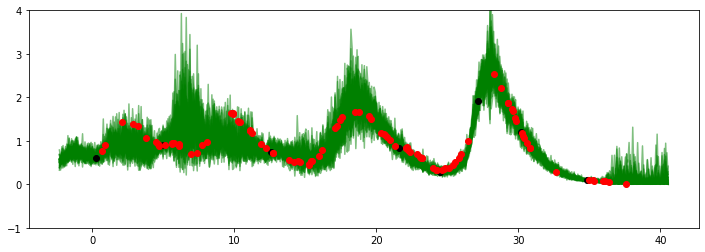

Validation neg. log-lik: -49.20
True data  neg. log-lik: 11.19
Training   neg. log-lik: -1.14, Encoder/decoder scales 0.129 0.097
Training   neg. log-lik: -47.77, Encoder/decoder scales 0.129 0.097
Training   neg. log-lik: -44.27, Encoder/decoder scales 0.129 0.097
Training   neg. log-lik: -67.76, Encoder/decoder scales 0.129 0.097
Training   neg. log-lik: -35.74, Encoder/decoder scales 0.128 0.097
Training   neg. log-lik: -29.93, Encoder/decoder scales 0.128 0.097
Training   neg. log-lik: -55.65, Encoder/decoder scales 0.128 0.097
Training   neg. log-lik: -63.05, Encoder/decoder scales 0.128 0.097
Training   neg. log-lik: -69.11, Encoder/decoder scales 0.128 0.097
Training   neg. log-lik: -70.07, Encoder/decoder scales 0.129 0.097
Training   neg. log-lik: -61.63, Encoder/decoder scales 0.128 0.097

Epoch: 27/101


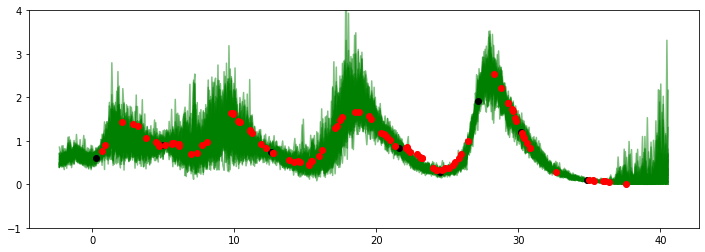

Validation neg. log-lik: -50.12
True data  neg. log-lik: 4.05
Training   neg. log-lik: -63.78, Encoder/decoder scales 0.128 0.097
Training   neg. log-lik: -70.23, Encoder/decoder scales 0.128 0.097
Training   neg. log-lik: -71.72, Encoder/decoder scales 0.128 0.097
Training   neg. log-lik: -72.71, Encoder/decoder scales 0.128 0.097
Training   neg. log-lik: 40.38, Encoder/decoder scales 0.128 0.097
Training   neg. log-lik: -53.09, Encoder/decoder scales 0.128 0.097
Training   neg. log-lik: -58.76, Encoder/decoder scales 0.127 0.097
Training   neg. log-lik: -63.31, Encoder/decoder scales 0.128 0.097
Training   neg. log-lik: -7.41, Encoder/decoder scales 0.128 0.097
Training   neg. log-lik: -61.88, Encoder/decoder scales 0.127 0.097
Training   neg. log-lik: -50.97, Encoder/decoder scales 0.128 0.097

Epoch: 28/101


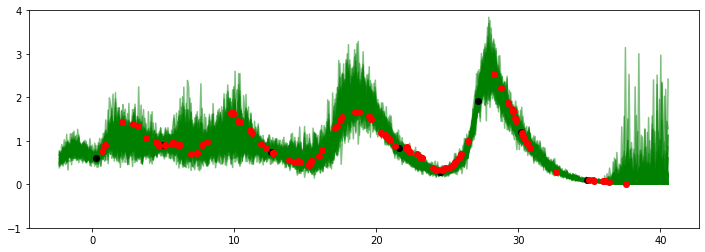

Validation neg. log-lik: -54.86
True data  neg. log-lik: 9.28
Training   neg. log-lik: -78.28, Encoder/decoder scales 0.128 0.097
Training   neg. log-lik: -63.23, Encoder/decoder scales 0.128 0.096
Training   neg. log-lik: -12.45, Encoder/decoder scales 0.128 0.096
Training   neg. log-lik: -36.95, Encoder/decoder scales 0.128 0.097
Training   neg. log-lik: -75.22, Encoder/decoder scales 0.128 0.097
Training   neg. log-lik: -73.26, Encoder/decoder scales 0.128 0.096
Training   neg. log-lik: -61.94, Encoder/decoder scales 0.128 0.096
Training   neg. log-lik: -71.94, Encoder/decoder scales 0.128 0.096
Training   neg. log-lik: -28.48, Encoder/decoder scales 0.128 0.096
Training   neg. log-lik: -68.61, Encoder/decoder scales 0.128 0.096
Training   neg. log-lik: 54.06, Encoder/decoder scales 0.129 0.096

Epoch: 29/101


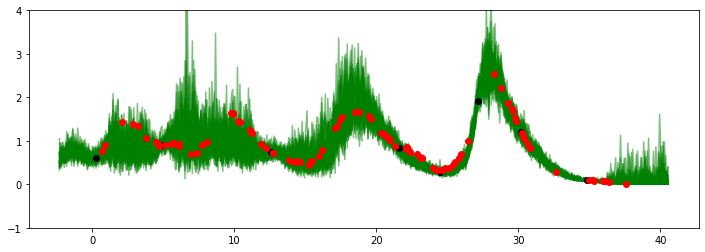

Validation neg. log-lik: -55.53
True data  neg. log-lik: 5.95
Training   neg. log-lik: -73.46, Encoder/decoder scales 0.129 0.096
Training   neg. log-lik: -57.77, Encoder/decoder scales 0.129 0.096
Training   neg. log-lik: -45.23, Encoder/decoder scales 0.129 0.096
Training   neg. log-lik: -40.27, Encoder/decoder scales 0.129 0.096
Training   neg. log-lik: -35.76, Encoder/decoder scales 0.129 0.096
Training   neg. log-lik: -62.68, Encoder/decoder scales 0.128 0.096
Training   neg. log-lik: -72.96, Encoder/decoder scales 0.128 0.096
Training   neg. log-lik: -80.66, Encoder/decoder scales 0.129 0.096
Training   neg. log-lik: -44.33, Encoder/decoder scales 0.129 0.096
Training   neg. log-lik: -54.94, Encoder/decoder scales 0.129 0.096
Training   neg. log-lik: -48.79, Encoder/decoder scales 0.128 0.096

Epoch: 30/101


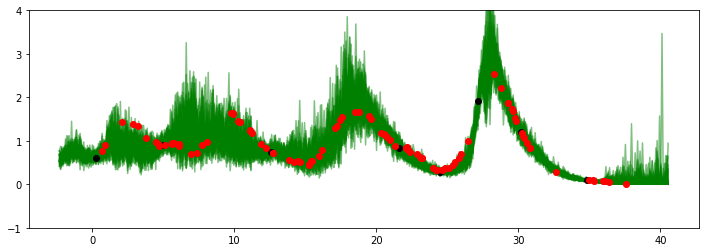

Validation neg. log-lik: -49.82
True data  neg. log-lik: 15.37
Training   neg. log-lik: -52.18, Encoder/decoder scales 0.129 0.096
Training   neg. log-lik: 31.11, Encoder/decoder scales 0.129 0.096
Training   neg. log-lik: -63.49, Encoder/decoder scales 0.129 0.096
Training   neg. log-lik: -48.19, Encoder/decoder scales 0.129 0.096
Training   neg. log-lik: -72.28, Encoder/decoder scales 0.130 0.096
Training   neg. log-lik: -77.91, Encoder/decoder scales 0.130 0.096
Training   neg. log-lik: -48.36, Encoder/decoder scales 0.130 0.096
Training   neg. log-lik: -75.02, Encoder/decoder scales 0.130 0.096
Training   neg. log-lik: -74.05, Encoder/decoder scales 0.130 0.096
Training   neg. log-lik: -38.30, Encoder/decoder scales 0.130 0.096
Training   neg. log-lik: -31.22, Encoder/decoder scales 0.130 0.096

Epoch: 31/101


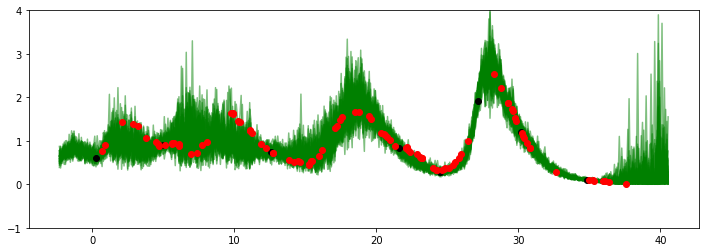

Validation neg. log-lik: -54.11
True data  neg. log-lik: 10.37
Training   neg. log-lik: -56.63, Encoder/decoder scales 0.130 0.096
Training   neg. log-lik: -67.82, Encoder/decoder scales 0.130 0.096
Training   neg. log-lik: -69.47, Encoder/decoder scales 0.130 0.096
Training   neg. log-lik: -9.35, Encoder/decoder scales 0.130 0.096
Training   neg. log-lik: -8.90, Encoder/decoder scales 0.130 0.096
Training   neg. log-lik: -63.27, Encoder/decoder scales 0.130 0.096
Training   neg. log-lik: -41.45, Encoder/decoder scales 0.130 0.096
Training   neg. log-lik: -26.14, Encoder/decoder scales 0.130 0.096
Training   neg. log-lik: 41.44, Encoder/decoder scales 0.130 0.096
Training   neg. log-lik: -26.97, Encoder/decoder scales 0.130 0.096
Training   neg. log-lik: -58.52, Encoder/decoder scales 0.130 0.096

Epoch: 32/101


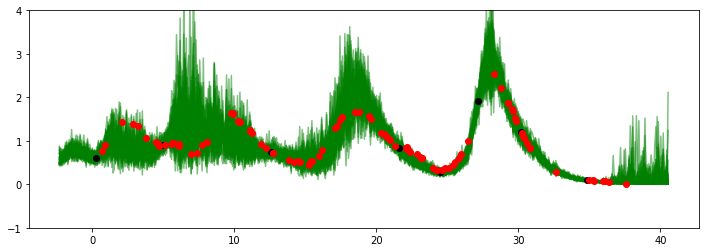

Validation neg. log-lik: -55.68
True data  neg. log-lik: 8.07
Training   neg. log-lik: -79.16, Encoder/decoder scales 0.130 0.096
Training   neg. log-lik: -54.41, Encoder/decoder scales 0.130 0.096
Training   neg. log-lik: 30.07, Encoder/decoder scales 0.131 0.096
Training   neg. log-lik: -49.33, Encoder/decoder scales 0.131 0.096
Training   neg. log-lik: -23.22, Encoder/decoder scales 0.131 0.096
Training   neg. log-lik: -72.45, Encoder/decoder scales 0.131 0.096
Training   neg. log-lik: -30.06, Encoder/decoder scales 0.132 0.096
Training   neg. log-lik: -31.73, Encoder/decoder scales 0.132 0.096
Training   neg. log-lik: -52.40, Encoder/decoder scales 0.132 0.096
Training   neg. log-lik: -67.54, Encoder/decoder scales 0.132 0.096
Training   neg. log-lik: -67.47, Encoder/decoder scales 0.132 0.096

Epoch: 33/101


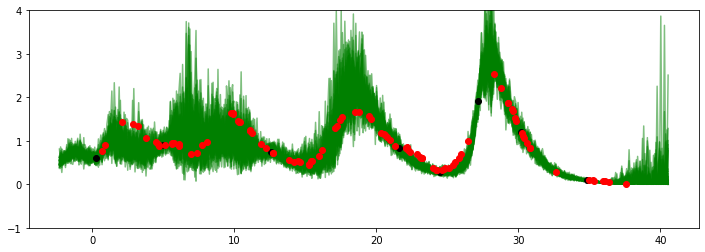

Validation neg. log-lik: -56.06
True data  neg. log-lik: 5.78
Training   neg. log-lik: -57.69, Encoder/decoder scales 0.132 0.096
Training   neg. log-lik: -63.00, Encoder/decoder scales 0.132 0.096
Training   neg. log-lik: -71.80, Encoder/decoder scales 0.133 0.096
Training   neg. log-lik: -72.11, Encoder/decoder scales 0.132 0.096
Training   neg. log-lik: 32.90, Encoder/decoder scales 0.132 0.096


KeyboardInterrupt: 

In [18]:
# =============================================================================
# Train or test model
# =============================================================================

# Number of epochs between validations
train_iteration = 0
log_every = 100

# Create optimiser
optimiser = torch.optim.Adam(model.parameters(),
                         args_learning_rate,
                         weight_decay=args_weight_decay)

# Run the training loop, maintaining the best objective value
best_nll = np.inf

epochs = len(data_train)

start_time = time.time()
for epoch in range(epochs):

    print('\nEpoch: {}/{}'.format(epoch+1, epochs))
    
    plot(model=model, data_train=data_train)

    if epoch % args_validate_every == 0:

        valid_epoch = data_val[0]

        # Compute negative log-likelihood on validation data
        val_nll, _, val_true_nll, _  = validate(valid_epoch,
                                                subsample_tasks,
                                                model,
                                                device,
                                                None,
                                                latent_model)

#         # Log information to tensorboard
#         writer.add_scalar('True data log-lik.',
#                           -true_nll,
#                           epoch)

#         # Log information to tensorboard
#         writer.add_scalar('Validation log-lik.',
#                           -val_nll,
#                           epoch)

        # Update the best objective value and checkpoint the model
        is_best, best_obj = (True, val_nll) if val_nll < best_nll else \
                            (False, best_nll)

    train_epoch = data_train[epoch]

    # Compute training negative log-likelihood
    train_iteration = train(train_epoch,
                            model,
                            optimiser,
                            log_every,
                            device,
                            None,
                            train_iteration)

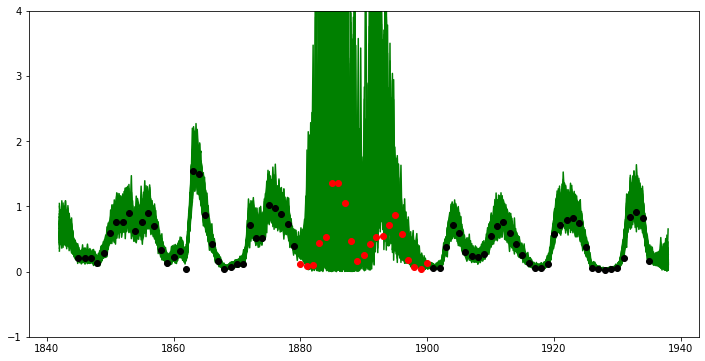

In [19]:
x_min = torch.min(holdout_task[0]['x_context'])
x_max = torch.max(holdout_task[0]['x_context'])
x_plot = torch.linspace(x_min-3., x_max+3., 500)[None, :, None].to(device)

x_ctx = holdout_task[0]['x_context']
y_ctx = holdout_task[0]['y_context']
x_trg = holdout_task[0]['x_target']
y_trg = holdout_task[0]['y_target']

with torch.no_grad():
    samples = [model.sample(x_ctx.to(device),
                            y_ctx.to(device) / 100 + 1e-2,
                            x_plot,
                            num_samples=10,
                            noiseless=False,
                            double=True)
               for i in range(10)]
    samples = torch.cat(samples, dim=0)

plt.figure(figsize=(12, 6))
plt.plot(x_plot[0, :, 0].cpu().detach().numpy(),
         samples[:, 0, :].cpu().detach().numpy().T,
         color='green',
         alpha=1.0,
         zorder=1)

# plt.plot(x_plot[0, :, 0].cpu().detach().numpy(),
#          torch.mean(samples[:, b_idx, :], axis=0).cpu().detach().numpy().T,
#          color='black',
#          alpha=0.5,
#          zorder=2)

plt.scatter(x_ctx[0, :, 0].detach().numpy(),
            y_ctx[0, :, 0].detach().numpy() / 100 + 1e-2,
            color='black',
            zorder=2)

plt.scatter(x_trg[0, :, 0].detach().numpy(),
            y_trg[0, :, 0].detach().numpy() / 100 + 1e-2,
            color='red',
            zorder=2)

plt.ylim([-1, 4])
plt.show()